In [3]:
import os
import cv2
import glob
import numpy as np

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers
from tensorflow.keras.models import Model

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# nếu không chưa cài đặt imgaug các bạn có thể dùng lệnh sau để cài đặt 
# pip install imgaug
from imgaug import augmenters as iaa


In [4]:
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    print("FOUND GPU")
else:
    print("GPU NOT FOUND")

FOUND GPU


## 100 Sports Image Classfication

In [5]:
IMAGES_PATH = "/media/aivn24/partition2/Khoa/AI2021/CNN_Generalize/data/100_Sports_Image_Classification"
RESULTS_LOG_PATH = "/media/aivn24/partition2/Khoa/AI2021/CNN_Generalize/results"
TRAIN_PATH = os.path.join(IMAGES_PATH, 'train')
VAL_PATH = os.path.join(IMAGES_PATH, 'valid')

BATCH_SIZE = 32
IMG_HEIGHT = IMG_WIDTH = 224
AUTOTUNE = tf.data.AUTOTUNE
EPOCHS = 70



In [6]:
class EDA_DATA():
    def __init__(self, data_path):
        self.data_path = data_path
        self.data_frame = self.make_data_frame()
        
        
    def make_data_frame(self):
        path_images = list(glob.glob(self.data_path+"/**/*.jpg"))
        labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], path_images))
        files_path = pd.Series(path_images, name="File_Path").astype('str')
        labels = pd.Series(labels, name='Labels')
        data = pd.concat([files_path, labels], axis=1)
        data = data.sample(frac=1).reset_index(drop=True)
        return data
    
    
    def show_data(self):
        fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10,10))
        for i, ax in enumerate(axes.flat):
            ax.imshow(plt.imread(self.data_frame["File_Path"][i]))
            ax.set_title(self.data_frame["Labels"][i])
            ax.axis('off')
        plt.tight_layout()
        plt.show()
    
    
    def show_sample_classes(self):
        plt.figure(figsize=(20,10))
        labels_counts = self.data_frame["Labels"].value_counts()
        sns.barplot(x=labels_counts.index, y=labels_counts)
        plt.xlabel("Labels")
        plt.ylabel("# Samples")
        plt.xticks(rotation=90)
        

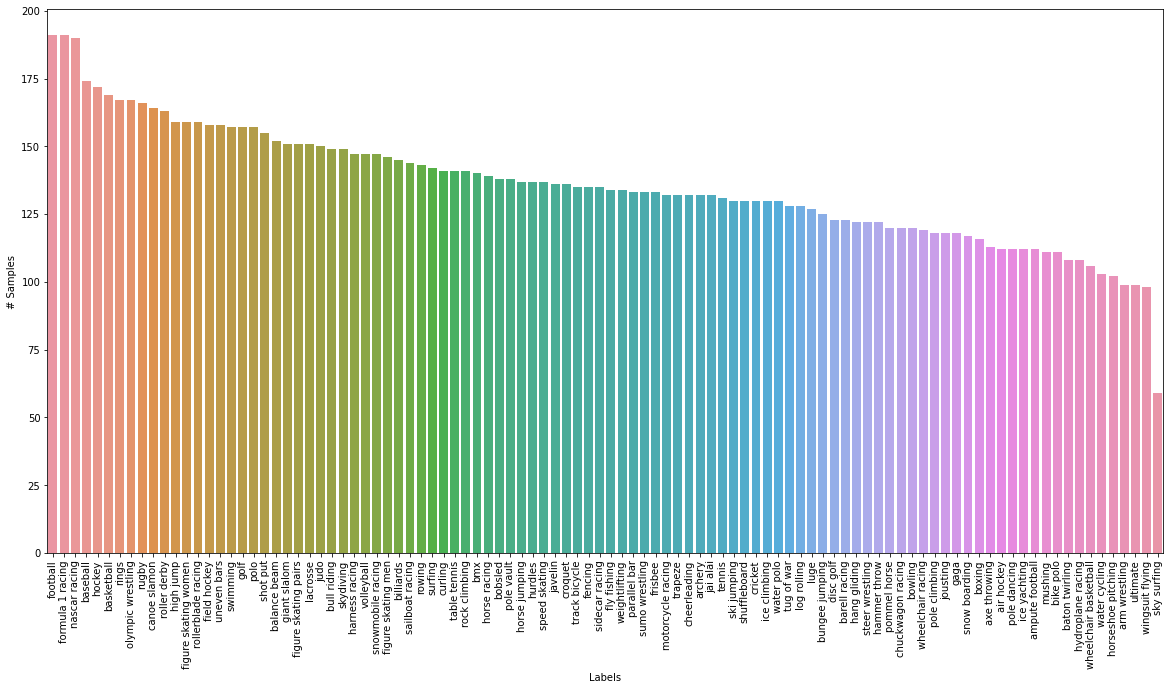

In [7]:
eda_100Sports = EDA_DATA(TRAIN_PATH)
eda_100Sports.show_sample_classes()

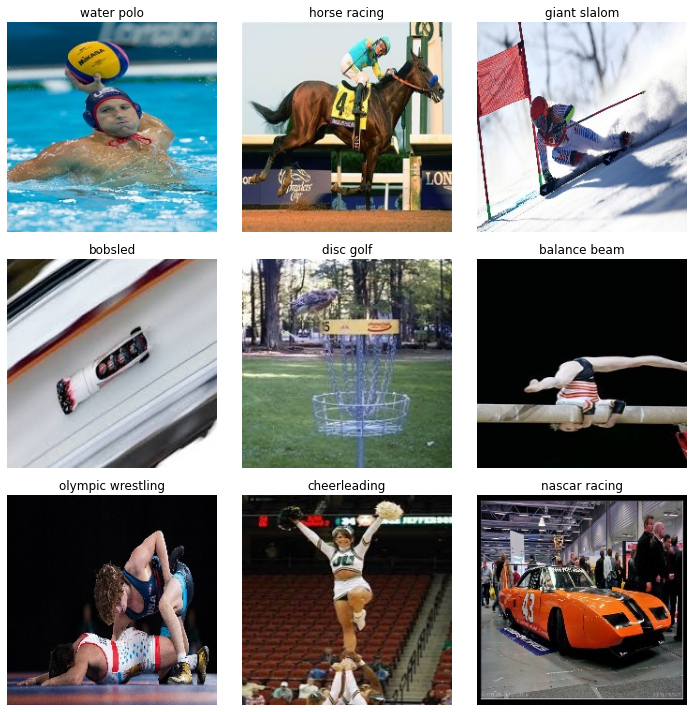

In [8]:
eda_100Sports.show_data()

In [9]:
del eda_100Sports

In [10]:
class DataLoader():
    def __init__(self, train_path_string, val_path_string):
        self.train_ds = tf.data.Dataset.list_files(train_path_string, shuffle=True)
        self.val_ds = tf.data.Dataset.list_files(val_path_string, shuffle=True)
        
        self.get_class_names(train_path_string)
    
    
    def get_class_names(self , path):
        self.class_names = sorted(os.listdir("/".join(path.split("/")[:-2])))
        print(self.class_names)
        
    
    def get_label(self, file_path):
        # Convert the path to a list of path components
        parts = tf.strings.split(file_path, os.path.sep)
        # The second to last is the class-directory
        one_hot = parts[-2] == self.class_names
        # Integer encode the label
        return tf.argmax(one_hot)

    
    def decode_img(self, img):
        # Convert the compressed string to a 3D uint8 tensor
        img = tf.io.decode_jpeg(img, channels=3)
        # Resize the image to the desired size
        return tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    
    
    def configure_for_performance(self, ds):
        #ds = ds.cache()
        ds = ds.shuffle(buffer_size=1000)
        ds = ds.batch(BATCH_SIZE)
        ds = ds.prefetch(buffer_size=AUTOTUNE)
        return ds
    
    
    def make_data(self):
        def process_path(file_path):
            label = self.get_label(file_path)
            # Load the raw data from the file as a string
            img = tf.io.read_file(file_path)
            img = self.decode_img(img)
            return img, label
        
        # Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
        self.train_ds = self.train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
        self.val_ds = self.val_ds.map(process_path, num_parallel_calls=AUTOTUNE)
        
        self.train_ds = self.configure_for_performance(self.train_ds)
        self.val_ds = self.configure_for_performance(self.val_ds)
        
        
        

In [11]:
train_path_string = TRAIN_PATH+"/**/*.jpg"
val_path_string = VAL_PATH+"/**/*.jpg"
ins100sport_dataloader = DataLoader(train_path_string, val_path_string)

['air hockey', 'ampute football', 'archery', 'arm wrestling', 'axe throwing', 'balance beam', 'barell racing', 'baseball', 'basketball', 'baton twirling', 'bike polo', 'billiards', 'bmx', 'bobsled', 'bowling', 'boxing', 'bull riding', 'bungee jumping', 'canoe slamon', 'cheerleading', 'chuckwagon racing', 'cricket', 'croquet', 'curling', 'disc golf', 'fencing', 'field hockey', 'figure skating men', 'figure skating pairs', 'figure skating women', 'fly fishing', 'football', 'formula 1 racing', 'frisbee', 'gaga', 'giant slalom', 'golf', 'hammer throw', 'hang gliding', 'harness racing', 'high jump', 'hockey', 'horse jumping', 'horse racing', 'horseshoe pitching', 'hurdles', 'hydroplane racing', 'ice climbing', 'ice yachting', 'jai alai', 'javelin', 'jousting', 'judo', 'lacrosse', 'log rolling', 'luge', 'motorcycle racing', 'mushing', 'nascar racing', 'olympic wrestling', 'parallel bar', 'pole climbing', 'pole dancing', 'pole vault', 'polo', 'pommel horse', 'rings', 'rock climbing', 'roller 

2022-02-20 11:34:13.107095: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-20 11:34:13.107990: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-20 11:34:13.108742: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-20 11:34:13.109417: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [12]:
ins100sport_dataloader.make_data()

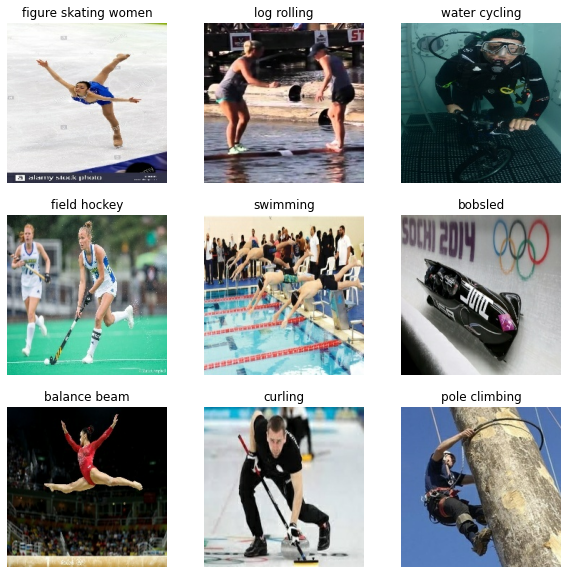

In [13]:
image_batch, label_batch = next(iter(ins100sport_dataloader.train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(ins100sport_dataloader.class_names[label])
  plt.axis("off")


###  Build Model

In [14]:
class RESNET34_V2():
    def __init__(self, normalization_layers_type=None, use_bias=True, 
                       kernel_regularizer=None, dropout_rate=None):
        
        self.normalization_layers_type  = normalization_layers_type
        self.use_bias              = use_bias
        self.kernel_regularizer    = kernel_regularizer
        self.dropout_rate          = dropout_rate
    
    def get_norm_layer(self, norm_type):
        NL_DICT = {
            'BN' : layers.BatchNormalization(),
            'LN' : layers.LayerNormalization(center=True, scale=True),
            'IN' : tfa.layers.InstanceNormalization(axis=3, 
                                   center=True, 
                                   scale=True,
                                   beta_initializer="random_uniform",
                                   gamma_initializer="random_uniform"),
            'GN' : tfa.layers.GroupNormalization()
        }
        
        norm_layer = NL_DICT[norm_type]
        return norm_layer
    
    
    def identity_block(self, inputs, filters):
        if self.normalization_layers_type is not None:
            x = self.get_norm_layer(self.normalization_layers_type)(inputs)
        else:
            x = inputs
        x = layers.Activation('relu')(x)
        x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same',
                         use_bias=self.use_bias, kernel_regularizer=self.kernel_regularizer)(x)
        
        
        if self.normalization_layers_type is not None:
            x = self.get_norm_layer(self.normalization_layers_type)(x)
        x = layers.Activation('relu')(x)
        x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same',
                         use_bias=self.use_bias, kernel_regularizer=self.kernel_regularizer)(x)
        
        x = layers.Add()([inputs,x])
        return x
    
    
    def projection_block(self, inputs, filters, strides=2):
        if self.normalization_layers_type is not None:
            inputs = self.get_norm_layer(self.normalization_layers_type)(inputs)
        
        inputs = layers.Activation('relu')(inputs)
        
        shortcut = layers.Conv2D(filters=filters*1, kernel_size=(1,1), padding='same', strides=strides,
                         use_bias=True, kernel_regularizer=self.kernel_regularizer)(inputs)
        
        
        x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', strides=strides,
                         use_bias=self.use_bias, kernel_regularizer=self.kernel_regularizer)(inputs)
       
        if self.normalization_layers_type is not None:
            x = self.get_norm_layer(self.normalization_layers_type)(x)
        x = layers.Activation('relu')(x)
        x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same',
                         use_bias=self.use_bias, kernel_regularizer=self.kernel_regularizer)(x)
              
        x = layers.Add()([shortcut,x])
        return x
    
    
    def build_model(self, num_classes=1000, input_shape=(224,224,3)):
        inputs = layers.Input(shape=input_shape)
        x = layers.ZeroPadding2D(padding=((3, 3), (3, 3)))(inputs)
        x = layers.Conv2D(filters=64, kernel_size=(7,7), strides=2, use_bias=True)(x)
        x = layers.ZeroPadding2D(padding=(1,1))(x)
        x = layers.MaxPooling2D(pool_size=(3,3), strides=2)(x)
        
        # conv2_X
        x = self.projection_block(x, filters=64, strides=1)
        x = self.identity_block(x, filters=64)
        x = self.identity_block(x, filters=64)
        if self.dropout_rate is not None:
            x = layers.Dropout(self.dropout_rate)(x)
        
        # conv3_x
        x = self.projection_block(x, filters=128)
        x = self.identity_block(x, filters=128)
        x = self.identity_block(x, filters=128)
        x = self.identity_block(x, filters=128)
        if self.dropout_rate is not None:
            x = layers.Dropout(self.dropout_rate)(x)
            
        # conv4_x
        x = self.projection_block(x, filters=256)
        x = self.identity_block(x, filters=256)
        x = self.identity_block(x, filters=256)
        x = self.identity_block(x, filters=256)
        x = self.identity_block(x, filters=256)
        x = self.identity_block(x, filters=256)
        if self.dropout_rate is not None:
            x = layers.Dropout(self.dropout_rate)(x)
        
        # conv5_x
        x = self.projection_block(x, filters=512)
        x = self.identity_block(x, filters=512)
        x = self.identity_block(x, filters=512)
        if self.dropout_rate is not None:
            x = layers.Dropout(self.dropout_rate)(x)
        
        if self.normalization_layers_type is not None:
            x = self.get_norm_layer(self.normalization_layers_type)(x)
        x = layers.Activation('relu')(x)
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dense(num_classes, activation='softmax')(x)
        
        model = Model(inputs=inputs, outputs=x)
        
        return model

###  Train

In [15]:
resnet34_v2_base_class = RESNET34_V2(normalization_layers_type=None, use_bias=True, 
                       kernel_regularizer=None, dropout_rate=None)
resnet34_v2_base_model = resnet34_v2_base_class.build_model(num_classes=100, input_shape=(IMG_HEIGHT,IMG_WIDTH,3))


image_input = layers.Input(shape=(IMG_HEIGHT,IMG_WIDTH,3))
x = tf.keras.layers.Rescaling(scale=1./127.5, offset=-1)(image_input)
x = resnet34_v2_base_model(x)
sports_classify_resnet34_v2_base_model = Model(inputs=image_input, outputs=x)

sports_classify_resnet34_v2_base_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 model (Functional)          (None, 100)               21331620  
                                                                 
Total params: 21,331,620
Trainable params: 21,331,620
Non-trainable params: 0
_________________________________________________________________


In [16]:
sports_classify_resnet34_v2_base_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-2, momentum=0.9),
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                      metrics=['accuracy'])


In [17]:
history = sports_classify_resnet34_v2_base_model.fit(ins100sport_dataloader.train_ds,
                                epochs = EPOCHS,
                                validation_data = ins100sport_dataloader.val_ds)

Epoch 1/70


2022-02-20 11:34:21.105672: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8100
2022-02-20 11:34:22.470874: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


425/425 [==============================] - 42s 86ms/step - loss: 4.4136 - accuracy: 0.0230 - val_loss: 4.3272 - val_accuracy: 0.0200
Epoch 2/70
425/425 [==============================] - 20s 46ms/step - loss: 4.0333 - accuracy: 0.0619 - val_loss: 3.8403 - val_accuracy: 0.0780
Epoch 3/70
425/425 [==============================] - 20s 47ms/step - loss: 3.6785 - accuracy: 0.1042 - val_loss: 3.6864 - val_accuracy: 0.0880
Epoch 4/70
425/425 [==============================] - 20s 46ms/step - loss: 3.3708 - accuracy: 0.1594 - val_loss: 3.4174 - val_accuracy: 0.1620
Epoch 5/70
425/425 [==============================] - 20s 46ms/step - loss: 3.0897 - accuracy: 0.2090 - val_loss: 2.8758 - val_accuracy: 0.2560
Epoch 6/70
425/425 [==============================] - 20s 46ms/step - loss: 2.7684 - accuracy: 0.2851 - val_loss: 2.8989 - val_accuracy: 0.2340
Epoch 7/70
425/425 [==============================] - 20s 47ms/step - loss: 2.4642 - accuracy: 0.3455 - val_loss: 2.4070 - val_accuracy: 0.4000
Epo

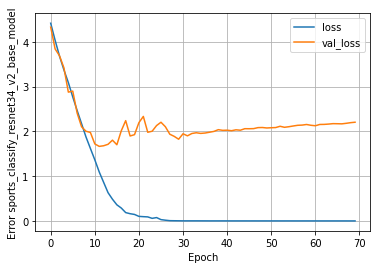

In [18]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Error sports_classify_resnet34_v2_base_model')
plt.legend()
plt.grid(True)

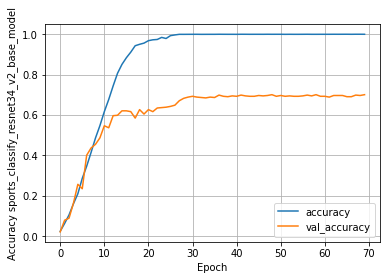

In [19]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy sports_classify_resnet34_v2_base_model')
plt.legend()
plt.grid(True)

In [20]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
65,0.000990,0.999484,2.170517,0.690,65
66,0.001106,0.999263,2.167993,0.690,66
67,0.001009,0.999484,2.179833,0.698,67
68,0.000943,0.999484,2.194215,0.696,68
69,0.001057,0.999337,2.204163,0.700,69


## Build Model with Built-in Normalization Layers

### Batch Normalization 


In [22]:
resnet34_v2_BN_class = RESNET34_V2(normalization_layers_type="BN", use_bias=False, 
                       kernel_regularizer=None, dropout_rate=None)
resnet34_v2_BN_model = resnet34_v2_BN_class.build_model(num_classes=100, input_shape=(IMG_HEIGHT,IMG_WIDTH,3))


image_input = layers.Input(shape=(IMG_HEIGHT,IMG_WIDTH,3))
x = tf.keras.layers.Rescaling(scale=1./127.5, offset=-1)(image_input)
x = resnet34_v2_BN_model(x)
sports_classify_resnet34_v2_BN_model = Model(inputs=image_input, outputs=x)

sports_classify_resnet34_v2_BN_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 model_2 (Functional)        (None, 100)               21354532  
                                                                 
Total params: 21,354,532
Trainable params: 21,339,300
Non-trainable params: 15,232
_________________________________________________________________


In [23]:
sports_classify_resnet34_v2_BN_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-2, momentum=0.9),
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                      metrics=['accuracy'])


In [24]:
history = sports_classify_resnet34_v2_BN_model.fit(ins100sport_dataloader.train_ds,
                                epochs = EPOCHS,
                                validation_data = ins100sport_dataloader.val_ds)

Epoch 1/70
425/425 [==============================] - 23s 51ms/step - loss: 3.7992 - accuracy: 0.1087 - val_loss: 3.5861 - val_accuracy: 0.1500
Epoch 2/70
425/425 [==============================] - 22s 51ms/step - loss: 2.9395 - accuracy: 0.2512 - val_loss: 2.8780 - val_accuracy: 0.2600
Epoch 3/70
425/425 [==============================] - 22s 51ms/step - loss: 2.4158 - accuracy: 0.3659 - val_loss: 2.3931 - val_accuracy: 0.3380
Epoch 4/70
425/425 [==============================] - 22s 51ms/step - loss: 2.0159 - accuracy: 0.4529 - val_loss: 2.3448 - val_accuracy: 0.3800
Epoch 5/70
425/425 [==============================] - 22s 51ms/step - loss: 1.6526 - accuracy: 0.5422 - val_loss: 2.3337 - val_accuracy: 0.4160
Epoch 6/70
425/425 [==============================] - 22s 52ms/step - loss: 1.3611 - accuracy: 0.6147 - val_loss: 1.8230 - val_accuracy: 0.4760
Epoch 7/70
425/425 [==============================] - 22s 52ms/step - loss: 1.1042 - accuracy: 0.6841 - val_loss: 2.6246 - val_accuracy:

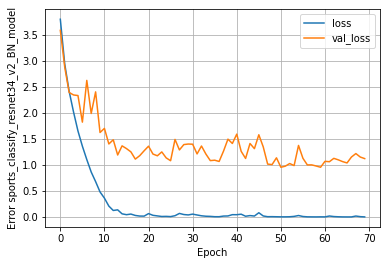

In [25]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Error sports_classify_resnet34_v2_BN_model')
plt.legend()
plt.grid(True)

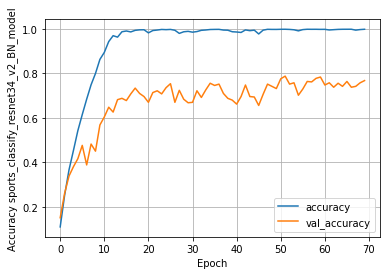

In [26]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy sports_classify_resnet34_v2_BN_model')
plt.legend()
plt.grid(True)

In [27]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
65,0.002504,0.999189,1.039495,0.764,65
66,0.002599,0.999263,1.153177,0.738,66
67,0.019210,0.995211,1.219170,0.742,67
68,0.007594,0.997790,1.152415,0.758,68
69,0.002873,0.999189,1.122605,0.768,69


### Layer Normalization 


In [29]:
resnet34_v2_LN_class = RESNET34_V2(normalization_layers_type="LN", use_bias=False, 
                       kernel_regularizer=None, dropout_rate=None)
resnet34_v2_LN_model = resnet34_v2_LN_class.build_model(num_classes=100, input_shape=(IMG_HEIGHT,IMG_WIDTH,3))


image_input = layers.Input(shape=(IMG_HEIGHT,IMG_WIDTH,3))
x = tf.keras.layers.Rescaling(scale=1./127.5, offset=-1)(image_input)
x = resnet34_v2_LN_model(x)
sports_classify_resnet34_v2_LN_model = Model(inputs=image_input, outputs=x)

sports_classify_resnet34_v2_LN_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 model_4 (Functional)        (None, 100)               21339300  
                                                                 
Total params: 21,339,300
Trainable params: 21,339,300
Non-trainable params: 0
_________________________________________________________________


In [30]:
sports_classify_resnet34_v2_LN_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-2, momentum=0.9),
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                      metrics=['accuracy'])


In [31]:
history = sports_classify_resnet34_v2_LN_model.fit(ins100sport_dataloader.train_ds,
                                epochs = EPOCHS,
                                validation_data = ins100sport_dataloader.val_ds)

Epoch 1/70
425/425 [==============================] - 34s 76ms/step - loss: 4.6429 - accuracy: 0.0149 - val_loss: 4.3855 - val_accuracy: 0.0280
Epoch 2/70
425/425 [==============================] - 33s 77ms/step - loss: 4.3252 - accuracy: 0.0224 - val_loss: 4.3069 - val_accuracy: 0.0300
Epoch 3/70
425/425 [==============================] - 33s 77ms/step - loss: 4.2340 - accuracy: 0.0318 - val_loss: 4.2194 - val_accuracy: 0.0340
Epoch 4/70
425/425 [==============================] - 33s 77ms/step - loss: 4.1374 - accuracy: 0.0435 - val_loss: 4.0698 - val_accuracy: 0.0520
Epoch 5/70
425/425 [==============================] - 33s 77ms/step - loss: 4.0243 - accuracy: 0.0585 - val_loss: 3.8945 - val_accuracy: 0.0780
Epoch 6/70
425/425 [==============================] - 33s 77ms/step - loss: 3.8502 - accuracy: 0.0831 - val_loss: 3.6992 - val_accuracy: 0.1080
Epoch 7/70
425/425 [==============================] - 33s 76ms/step - loss: 3.6644 - accuracy: 0.1100 - val_loss: 3.5221 - val_accuracy:

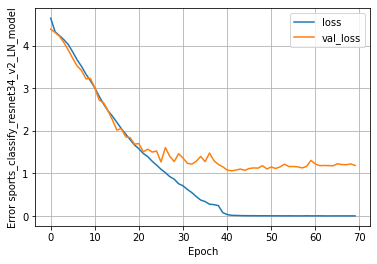

In [32]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Error sports_classify_resnet34_v2_LN_model')
plt.legend()
plt.grid(True)

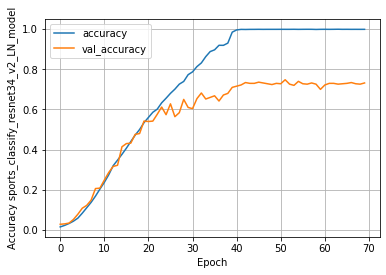

In [33]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy sports_classify_resnet34_v2_LN_model')
plt.legend()
plt.grid(True)

In [34]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
65,0.003576,0.999263,1.226555,0.730,65
66,0.003962,0.999042,1.207335,0.734,66
67,0.003787,0.999116,1.203041,0.728,67
68,0.003706,0.999042,1.223189,0.726,68
69,0.003834,0.999116,1.187815,0.732,69


### Instance Normalization 


In [36]:


resnet34_v2_IN_class = RESNET34_V2(normalization_layers_type="IN", use_bias=False, 
                       kernel_regularizer=None, dropout_rate=None)
resnet34_v2_IN_model = resnet34_v2_IN_class.build_model(num_classes=100, input_shape=(IMG_HEIGHT,IMG_WIDTH,3))


image_input = layers.Input(shape=(IMG_HEIGHT,IMG_WIDTH,3))
x = tf.keras.layers.Rescaling(scale=1./127.5, offset=-1)(image_input)
x = resnet34_v2_IN_model(x)
sports_classify_resnet34_v2_IN_model = Model(inputs=image_input, outputs=x)

sports_classify_resnet34_v2_IN_model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_3 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 model_6 (Functional)        (None, 100)               21339300  
                                                                 
Total params: 21,339,300
Trainable params: 21,339,300
Non-trainable params: 0
_________________________________________________________________


In [43]:
sports_classify_resnet34_v2_IN_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-2, momentum=0.9),
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                      metrics=['accuracy'])


In [44]:
history = sports_classify_resnet34_v2_IN_model.fit(ins100sport_dataloader.train_ds,
                                epochs = EPOCHS,
                                validation_data = ins100sport_dataloader.val_ds)

Epoch 1/70
425/425 [==============================] - 31s 67ms/step - loss: 4.5926 - accuracy: 0.0130 - val_loss: 4.6151 - val_accuracy: 0.0100
Epoch 2/70
425/425 [==============================] - 28s 66ms/step - loss: 4.5906 - accuracy: 0.0140 - val_loss: 4.6123 - val_accuracy: 0.0160
Epoch 3/70
425/425 [==============================] - 28s 66ms/step - loss: 4.5858 - accuracy: 0.0137 - val_loss: 4.6046 - val_accuracy: 0.0100
Epoch 4/70
425/425 [==============================] - 28s 66ms/step - loss: 4.5729 - accuracy: 0.0144 - val_loss: 4.5850 - val_accuracy: 0.0140
Epoch 5/70
425/425 [==============================] - 28s 66ms/step - loss: 4.5381 - accuracy: 0.0225 - val_loss: 4.5361 - val_accuracy: 0.0220
Epoch 6/70
425/425 [==============================] - 28s 66ms/step - loss: 4.4751 - accuracy: 0.0245 - val_loss: 4.4613 - val_accuracy: 0.0180
Epoch 7/70
425/425 [==============================] - 28s 66ms/step - loss: 4.3960 - accuracy: 0.0284 - val_loss: 4.3782 - val_accuracy:

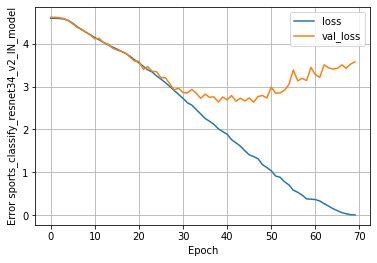

In [45]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Error sports_classify_resnet34_v2_IN_model')
plt.legend()
plt.grid(True)

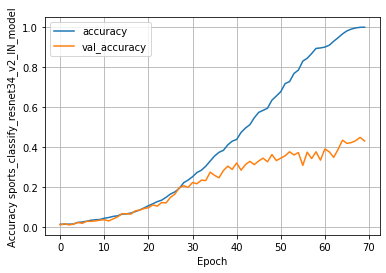

In [46]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy sports_classify_resnet34_v2_IN_model')
plt.legend()
plt.grid(True)

In [47]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
65,0.108043,0.980843,3.424191,0.418,65
66,0.062266,0.989979,3.506116,0.422,66
67,0.036505,0.995800,3.425408,0.432,67
68,0.015245,0.998821,3.526804,0.448,68
69,0.009404,0.999116,3.574433,0.430,69


### Group Normalization 

In [49]:
resnet34_v2_GN_class = RESNET34_V2(normalization_layers_type="GN", use_bias=False, 
                       kernel_regularizer=None, dropout_rate=None)
resnet34_v2_GN_model = resnet34_v2_GN_class.build_model(num_classes=100, input_shape=(IMG_HEIGHT,IMG_WIDTH,3))

image_input = layers.Input(shape=(IMG_HEIGHT,IMG_WIDTH,3))
x = tf.keras.layers.Rescaling(scale=1./127.5, offset=-1)(image_input)
x = resnet34_v2_GN_model(x)
sports_classify_resnet34_v2_GN_model = Model(inputs=image_input, outputs=x)

sports_classify_resnet34_v2_GN_model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_4 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 model_8 (Functional)        (None, 100)               21339300  
                                                                 
Total params: 21,339,300
Trainable params: 21,339,300
Non-trainable params: 0
_________________________________________________________________


In [50]:
sports_classify_resnet34_v2_GN_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-2, momentum=0.9),
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                      metrics=['accuracy'])


In [51]:
history = sports_classify_resnet34_v2_GN_model.fit(ins100sport_dataloader.train_ds,
                                epochs = EPOCHS,
                                validation_data = ins100sport_dataloader.val_ds)

Epoch 1/70
425/425 [==============================] - 35s 75ms/step - loss: 4.6485 - accuracy: 0.0142 - val_loss: 4.5304 - val_accuracy: 0.0160
Epoch 2/70
425/425 [==============================] - 31s 74ms/step - loss: 4.4642 - accuracy: 0.0251 - val_loss: 4.3362 - val_accuracy: 0.0320
Epoch 3/70
425/425 [==============================] - 31s 74ms/step - loss: 4.1991 - accuracy: 0.0443 - val_loss: 4.1928 - val_accuracy: 0.0420
Epoch 4/70
425/425 [==============================] - 32s 74ms/step - loss: 3.9596 - accuracy: 0.0659 - val_loss: 3.8661 - val_accuracy: 0.0640
Epoch 5/70
425/425 [==============================] - 32s 74ms/step - loss: 3.7084 - accuracy: 0.0993 - val_loss: 3.5830 - val_accuracy: 0.1420
Epoch 6/70
425/425 [==============================] - 31s 74ms/step - loss: 3.4634 - accuracy: 0.1390 - val_loss: 3.4578 - val_accuracy: 0.1280
Epoch 7/70
425/425 [==============================] - 31s 74ms/step - loss: 3.2400 - accuracy: 0.1750 - val_loss: 3.2955 - val_accuracy:

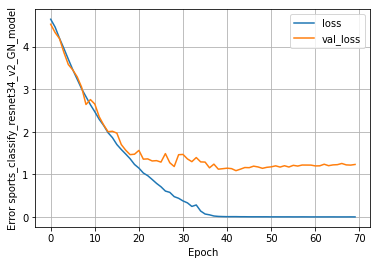

In [52]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Error sports_classify_resnet34_v2_GN_model')
plt.legend()
plt.grid(True)

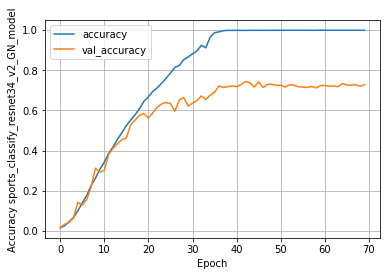

In [53]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy sports_classify_resnet34_v2_GN_model')
plt.legend()
plt.grid(True)

In [54]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
65,0.002618,0.999337,1.230583,0.726,65
66,0.002764,0.999263,1.258486,0.726,66
67,0.002667,0.999263,1.225175,0.728,67
68,0.003295,0.999116,1.220045,0.720,68
69,0.002405,0.999263,1.235301,0.728,69


## Kernel Regularization & Dropout: 

### Kernel Regularization

In [ ]:
kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)
resnet34_v2_kr_class = RESNET34_V2(normalization_layers_type=None, use_bias= False, 
                       kernel_regularizer=kernel_regularizer, dropout_rate=None)
resnet34_v2_kr_model = resnet34_v2_kr_class.build_model(num_classes=100, input_shape=(IMG_HEIGHT,IMG_WIDTH,3))


image_input = layers.Input(shape=(IMG_HEIGHT,IMG_WIDTH,3))
x = tf.keras.layers.Rescaling(scale=1./127.5, offset=-1)(image_input)
x = resnet34_v2_kr_model(x)
sports_classify_resnet34_v2_kr_model = Model(inputs=image_input, outputs=x)

sports_classify_resnet34_v2_kr_model.summary()

In [63]:
sports_classify_resnet34_v2_kr_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-2, momentum=0.9),
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                      metrics=['accuracy'])


In [64]:
history = sports_classify_resnet34_v2_kr_model.fit(ins100sport_dataloader.train_ds,
                                epochs = EPOCHS,
                                validation_data = ins100sport_dataloader.val_ds)

Epoch 1/70
425/425 [==============================] - 22s 49ms/step - loss: 4.5965 - accuracy: 0.0134 - val_loss: 4.6201 - val_accuracy: 0.0100
Epoch 2/70
425/425 [==============================] - 21s 49ms/step - loss: 4.5949 - accuracy: 0.0141 - val_loss: 4.6192 - val_accuracy: 0.0100
Epoch 3/70
425/425 [==============================] - 20s 48ms/step - loss: 4.5941 - accuracy: 0.0134 - val_loss: 4.6187 - val_accuracy: 0.0100
Epoch 4/70
425/425 [==============================] - 21s 49ms/step - loss: 4.5938 - accuracy: 0.0128 - val_loss: 4.6186 - val_accuracy: 0.0100
Epoch 5/70
425/425 [==============================] - 21s 48ms/step - loss: 4.5937 - accuracy: 0.0141 - val_loss: 4.6187 - val_accuracy: 0.0100
Epoch 6/70
425/425 [==============================] - 21s 49ms/step - loss: 4.5937 - accuracy: 0.0128 - val_loss: 4.6187 - val_accuracy: 0.0100
Epoch 7/70
425/425 [==============================] - 21s 49ms/step - loss: 4.5937 - accuracy: 0.0133 - val_loss: 4.6189 - val_accuracy:

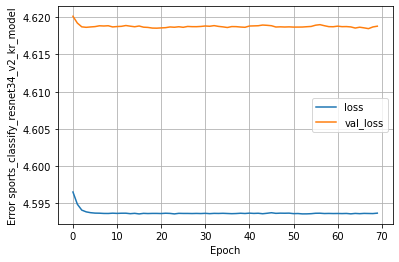

In [65]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Error sports_classify_resnet34_v2_kr_model')
plt.legend()
plt.grid(True)

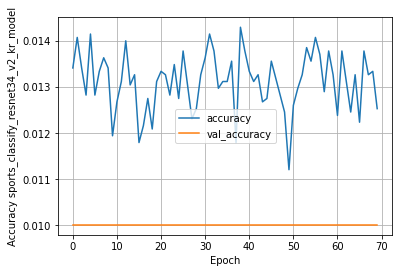

In [66]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy sports_classify_resnet34_v2_kr_model')
plt.legend()
plt.grid(True)

In [67]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
65,4.593588,0.012231,4.618661,0.01,65
66,4.593625,0.013778,4.618572,0.01,66
67,4.593613,0.013263,4.618468,0.01,67
68,4.593602,0.013336,4.618697,0.01,68
69,4.593657,0.012526,4.618797,0.01,69


### Dropout

In [72]:
dropout_rate = 0.5
resnet34_v2_do_class = RESNET34_V2(normalization_layers_type=None, use_bias=False, 
                       kernel_regularizer=None, dropout_rate=dropout_rate)
resnet34_v2_do_model = resnet34_v2_do_class.build_model(num_classes=100, input_shape=(IMG_HEIGHT,IMG_WIDTH,3))


image_input = layers.Input(shape=(IMG_HEIGHT,IMG_WIDTH,3))
x = tf.keras.layers.Rescaling(scale=1./127.5, offset=-1)(image_input)
x = resnet34_v2_do_model(x)
sports_classify_resnet34_v2_do_model = Model(inputs=image_input, outputs=x)

sports_classify_resnet34_v2_do_model.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_7 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 model_14 (Functional)       (None, 100)               21324068  
                                                                 
Total params: 21,324,068
Trainable params: 21,324,068
Non-trainable params: 0
_________________________________________________________________


In [79]:
dropout_rate = 0.5
resnet34_v2_do_class = RESNET34_V2(normalization_layers_type=None, use_bias=False, 
                       kernel_regularizer=None, dropout_rate=dropout_rate)
resnet34_v2_do_model = resnet34_v2_do_class.build_model(num_classes=100, input_shape=(IMG_HEIGHT,IMG_WIDTH,3))


image_input = layers.Input(shape=(IMG_HEIGHT,IMG_WIDTH,3))
x = tf.keras.layers.Rescaling(scale=1./127.5, offset=-1)(image_input)
x = resnet34_v2_do_model(x)
sports_classify_resnet34_v2_do_model = Model(inputs=image_input, outputs=x)

sports_classify_resnet34_v2_do_model.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_8 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 model_16 (Functional)       (None, 100)               21324068  
                                                                 
Total params: 21,324,068
Trainable params: 21,324,068
Non-trainable params: 0
_________________________________________________________________


In [80]:
sports_classify_resnet34_v2_do_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-2, momentum=0.9),
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                      metrics=['accuracy'])


In [81]:
history = sports_classify_resnet34_v2_do_model.fit(ins100sport_dataloader.train_ds,
                                epochs = EPOCHS,
                                validation_data = ins100sport_dataloader.val_ds)

Epoch 1/70
425/425 [==============================] - 21s 48ms/step - loss: 4.5619 - accuracy: 0.0153 - val_loss: 4.5982 - val_accuracy: 0.0100
Epoch 2/70
425/425 [==============================] - 20s 46ms/step - loss: 4.4468 - accuracy: 0.0245 - val_loss: 4.3601 - val_accuracy: 0.0280
Epoch 3/70
425/425 [==============================] - 21s 48ms/step - loss: 4.2339 - accuracy: 0.0322 - val_loss: 4.2004 - val_accuracy: 0.0280
Epoch 4/70
425/425 [==============================] - 20s 47ms/step - loss: 3.9891 - accuracy: 0.0567 - val_loss: 3.8361 - val_accuracy: 0.0660
Epoch 5/70
425/425 [==============================] - 20s 47ms/step - loss: 3.8111 - accuracy: 0.0799 - val_loss: 3.8148 - val_accuracy: 0.0620
Epoch 6/70
425/425 [==============================] - 21s 48ms/step - loss: 3.6351 - accuracy: 0.1141 - val_loss: 3.7399 - val_accuracy: 0.0940
Epoch 7/70
425/425 [==============================] - 20s 47ms/step - loss: 3.4367 - accuracy: 0.1482 - val_loss: 3.5840 - val_accuracy:

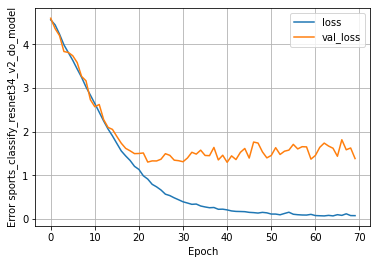

In [82]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Error sports_classify_resnet34_v2_do_model')
plt.legend()
plt.grid(True)

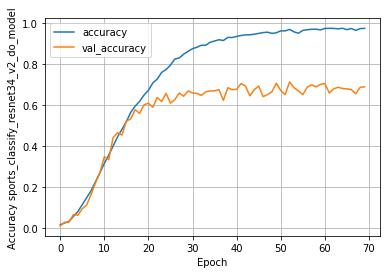

In [83]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy sports_classify_resnet34_v2_do_model')
plt.legend()
plt.grid(True)

In [84]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
65,0.101187,0.969643,1.438029,0.680,65
66,0.085311,0.975169,1.816955,0.676,66
67,0.121111,0.965886,1.587459,0.656,67
68,0.080487,0.974801,1.628196,0.688,68
69,0.079058,0.975906,1.385685,0.690,69


## Data Augmentation

In [86]:
rand_aug = iaa.RandAugment(n=3, m=7)


def augment(images):
    # Input to `augment()` is a TensorFlow tensor which
    # is not supported by `imgaug`. This is why we first
    # convert it to its `numpy` variant.
    images = tf.cast(images, tf.uint8)
    return rand_aug(images=images.numpy())

In [87]:
train_ds_rand = ins100sport_dataloader.train_ds.map(
        lambda x, y: (tf.py_function(augment, [x], [tf.float32])[0], y),
        num_parallel_calls=tf.data.AUTOTUNE,
    )

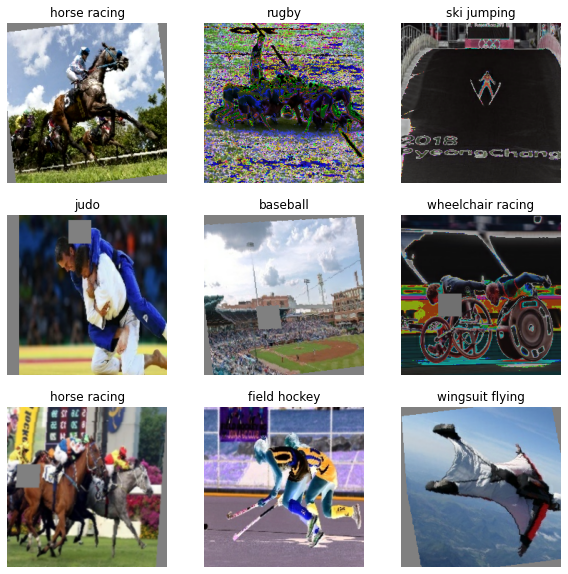

In [88]:
image_batch, label_batch = next(iter(train_ds_rand))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(ins100sport_dataloader.class_names[label])
  plt.axis("off")


### Batch Norm + Augmentation

In [89]:
resnet34_v2_aug_class = RESNET34_V2(normalization_layers_type="BN", use_bias=False, 
                       kernel_regularizer=None, dropout_rate=None)
resnet34_v2_aug_model = resnet34_v2_aug_class.build_model(num_classes=100, input_shape=(IMG_HEIGHT,IMG_WIDTH,3))


image_input = layers.Input(shape=(IMG_HEIGHT,IMG_WIDTH,3))
x = tf.keras.layers.Rescaling(scale=1./127.5, offset=-1)(image_input)
x = resnet34_v2_aug_model(x)
sports_classify_resnet34_v2_aug_model = Model(inputs=image_input, outputs=x)

sports_classify_resnet34_v2_aug_model.summary()

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_9 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 model_18 (Functional)       (None, 100)               21354532  
                                                                 
Total params: 21,354,532
Trainable params: 21,339,300
Non-trainable params: 15,232
_________________________________________________________________


In [90]:
sports_classify_resnet34_v2_aug_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-2, momentum=0.9),
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                      metrics=['accuracy'])


In [91]:
history = sports_classify_resnet34_v2_aug_model.fit(train_ds_rand,
                                epochs = EPOCHS,
                                validation_data = ins100sport_dataloader.val_ds)

Epoch 1/70
425/425 [==============================] - 24s 54ms/step - loss: 4.3254 - accuracy: 0.0520 - val_loss: 5.1947 - val_accuracy: 0.0420
Epoch 2/70
425/425 [==============================] - 23s 53ms/step - loss: 3.7384 - accuracy: 0.1216 - val_loss: 3.5736 - val_accuracy: 0.1620
Epoch 3/70
425/425 [==============================] - 23s 53ms/step - loss: 3.3444 - accuracy: 0.1848 - val_loss: 3.0170 - val_accuracy: 0.2180
Epoch 4/70
425/425 [==============================] - 23s 53ms/step - loss: 3.0284 - accuracy: 0.2414 - val_loss: 2.6202 - val_accuracy: 0.3380
Epoch 5/70
425/425 [==============================] - 23s 53ms/step - loss: 2.7631 - accuracy: 0.2987 - val_loss: 2.7719 - val_accuracy: 0.3160
Epoch 6/70
425/425 [==============================] - 23s 53ms/step - loss: 2.5225 - accuracy: 0.3529 - val_loss: 2.4521 - val_accuracy: 0.3960
Epoch 7/70
425/425 [==============================] - 23s 53ms/step - loss: 2.3225 - accuracy: 0.3955 - val_loss: 1.9603 - val_accuracy:

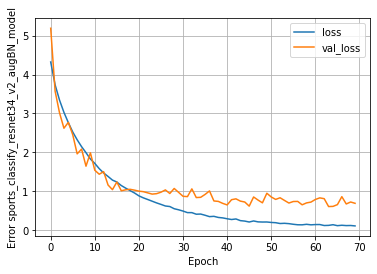

In [92]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Error sports_classify_resnet34_v2_augBN_model')
plt.legend()
plt.grid(True)

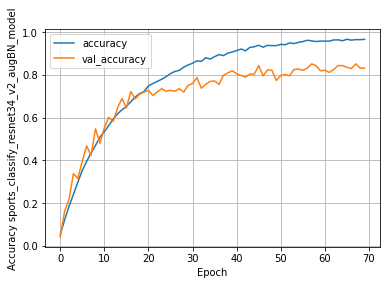

In [93]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy sports_classify_resnet34_v2_augBN_model')
plt.legend()
plt.grid(True)

In [94]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
65,0.110700,0.967359,0.652755,0.836,65
66,0.121118,0.963159,0.857894,0.830,66
67,0.112810,0.965665,0.669830,0.852,67
68,0.115143,0.965223,0.720326,0.832,68
69,0.104326,0.966917,0.686521,0.832,69


### Augmentation 

In [96]:
resnet34_v2_aug_class = RESNET34_V2(normalization_layers_type=None, use_bias=True, 
                       kernel_regularizer=None, dropout_rate=None)
resnet34_v2_aug_model = resnet34_v2_aug_class.build_model(num_classes=100, input_shape=(IMG_HEIGHT,IMG_WIDTH,3))


image_input = layers.Input(shape=(IMG_HEIGHT,IMG_WIDTH,3))
x = tf.keras.layers.Rescaling(scale=1./127.5, offset=-1)(image_input)
x = resnet34_v2_aug_model(x)
sports_classify_resnet34_v2_aug_model = Model(inputs=image_input, outputs=x)

sports_classify_resnet34_v2_aug_model.summary()

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_10 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 model_20 (Functional)       (None, 100)               21331620  
                                                                 
Total params: 21,331,620
Trainable params: 21,331,620
Non-trainable params: 0
_________________________________________________________________


In [97]:
sports_classify_resnet34_v2_aug_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-2, momentum=0.9),
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                      metrics=['accuracy'])


In [98]:
history = sports_classify_resnet34_v2_aug_model.fit(train_ds_rand,
                                epochs = EPOCHS,
                                validation_data = ins100sport_dataloader.val_ds)

Epoch 1/70
425/425 [==============================] - 23s 51ms/step - loss: 4.5964 - accuracy: 0.0135 - val_loss: 4.6006 - val_accuracy: 0.0140
Epoch 2/70
425/425 [==============================] - 22s 51ms/step - loss: 4.5835 - accuracy: 0.0160 - val_loss: 4.6064 - val_accuracy: 0.0100
Epoch 3/70
425/425 [==============================] - 23s 53ms/step - loss: 4.5458 - accuracy: 0.0169 - val_loss: 4.4234 - val_accuracy: 0.0240
Epoch 4/70
425/425 [==============================] - 23s 52ms/step - loss: 4.4829 - accuracy: 0.0244 - val_loss: 4.3513 - val_accuracy: 0.0260
Epoch 5/70
425/425 [==============================] - 22s 51ms/step - loss: 4.3154 - accuracy: 0.0385 - val_loss: 4.1299 - val_accuracy: 0.0500
Epoch 6/70
425/425 [==============================] - 22s 52ms/step - loss: 4.0960 - accuracy: 0.0605 - val_loss: 3.8066 - val_accuracy: 0.0840
Epoch 7/70
425/425 [==============================] - 22s 51ms/step - loss: 3.8990 - accuracy: 0.0863 - val_loss: 3.7425 - val_accuracy:

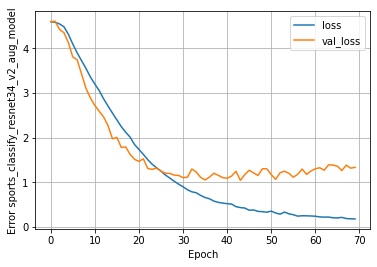

In [99]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Error sports_classify_resnet34_v2_aug_model')
plt.legend()
plt.grid(True)

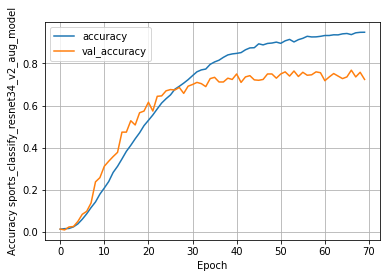

In [100]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy sports_classify_resnet34_v2_aug_model')
plt.legend()
plt.grid(True)

In [101]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
65,0.198552,0.942087,1.358359,0.736,65
66,0.211841,0.936782,1.260370,0.768,66
67,0.185592,0.945329,1.381094,0.736,67
68,0.179775,0.947613,1.314446,0.758,68
69,0.177293,0.947981,1.333123,0.724,69


##  Comparation

In [103]:
class RESNET34_V2_mix():
    def __init__(self, normalization_layers_type=None, use_bias=True, 
                       kernel_regularizer=None, dropout_rate=None):
        
        self.normalization_layers_type  = normalization_layers_type
        self.use_bias              = use_bias
        self.kernel_regularizer    = kernel_regularizer
        self.dropout_rate          = dropout_rate
    
    def get_norm_layer(self, norm_type):
        NL_DICT = {
            'BN' : layers.BatchNormalization(),
            'LN' : layers.LayerNormalization(center=True, scale=True),
            'IN' : tfa.layers.InstanceNormalization(axis=3, 
                                   center=True, 
                                   scale=True,
                                   beta_initializer="random_uniform",
                                   gamma_initializer="random_uniform"),
            'GN' : tfa.layers.GroupNormalization()
        }
        
        norm_layer = NL_DICT[norm_type]
        return norm_layer
    
    
    def identity_block(self, inputs, filters):
        if self.normalization_layers_type is not None:
            x = self.get_norm_layer(self.normalization_layers_type)(inputs)
            x = tfa.layers.InstanceNormalization(axis=3, 
                                   center=True, 
                                   scale=True,
                                   beta_initializer="random_uniform",
                                   gamma_initializer="random_uniform")(x)
        else:
            x = inputs
        x = layers.Activation('relu')(x)
        x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same',
                         use_bias=self.use_bias, kernel_regularizer=self.kernel_regularizer)(x)
        
        
        if self.normalization_layers_type is not None:
            x = self.get_norm_layer(self.normalization_layers_type)(x)
        x = layers.Activation('relu')(x)
        x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same',
                         use_bias=self.use_bias, kernel_regularizer=self.kernel_regularizer)(x)
        
        
#         if self.normalization_layers_type is not None:
#             x = self.get_norm_layer(self.normalization_layers_type)(x)
#         x = layers.Activation('relu')(x)
#         x = layers.Conv2D(filters=filters*4, kernel_size=(1,1), padding='same',
#                          use_bias=True, kernel_regularizer=self.kernel_regularizer)(x)
        
        x = layers.Add()([inputs,x])
        return x
    
    
    def projection_block(self, inputs, filters, strides=2):
        if self.normalization_layers_type is not None:
            inputs = self.get_norm_layer(self.normalization_layers_type)(inputs)
            inputs = tfa.layers.InstanceNormalization(axis=3, 
                                   center=True, 
                                   scale=True,
                                   beta_initializer="random_uniform",
                                   gamma_initializer="random_uniform")(inputs)
        else:
            x = inputs
        inputs = layers.Activation('relu')(inputs)
        
        shortcut = layers.Conv2D(filters=filters*1, kernel_size=(1,1), padding='same', strides=strides,
                         use_bias=True, kernel_regularizer=self.kernel_regularizer)(inputs)
        
        
        x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', strides=strides,
                         use_bias=self.use_bias, kernel_regularizer=self.kernel_regularizer)(inputs)
       
        if self.normalization_layers_type is not None:
            x = self.get_norm_layer(self.normalization_layers_type)(x)
        x = layers.Activation('relu')(x)
        x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same',
                         use_bias=self.use_bias, kernel_regularizer=self.kernel_regularizer)(x)
        
#         if self.normalization_layers_type is not None:
#             x = self.get_norm_layer(self.normalization_layers_type)(x)
#         x = layers.Activation('relu')(x)
#         x = layers.Conv2D(filters=filters*4, kernel_size=(1,1), padding='same',
#                          use_bias=True, kernel_regularizer=self.kernel_regularizer)(x)
        
        
        x = layers.Add()([shortcut,x])
        return x
    
    
    def build_model(self, num_classes=1000, input_shape=(224,224,3)):
        inputs = layers.Input(shape=input_shape)
        x = layers.ZeroPadding2D(padding=((3, 3), (3, 3)))(inputs)
        x = layers.Conv2D(filters=64, kernel_size=(7,7), strides=2, use_bias=True)(x)
        x = layers.ZeroPadding2D(padding=(1,1))(x)
        x = layers.MaxPooling2D(pool_size=(3,3), strides=2)(x)
        
        # conv2_X
        x = self.projection_block(x, filters=64, strides=1)
        x = self.identity_block(x, filters=64)
        x = self.identity_block(x, filters=64)
        if self.dropout_rate is not None:
            x = layers.Dropout(self.dropout_rate)(x)
        
        # conv3_x
        x = self.projection_block(x, filters=128)
        x = self.identity_block(x, filters=128)
        x = self.identity_block(x, filters=128)
        x = self.identity_block(x, filters=128)
        if self.dropout_rate is not None:
            x = layers.Dropout(self.dropout_rate)(x)
            
        # conv4_x
        x = self.projection_block(x, filters=256)
        x = self.identity_block(x, filters=256)
        x = self.identity_block(x, filters=256)
        x = self.identity_block(x, filters=256)
        x = self.identity_block(x, filters=256)
        x = self.identity_block(x, filters=256)
        if self.dropout_rate is not None:
            x = layers.Dropout(self.dropout_rate)(x)
        
        # conv5_x
        x = self.projection_block(x, filters=512)
        x = self.identity_block(x, filters=512)
        x = self.identity_block(x, filters=512)
        if self.dropout_rate is not None:
            x = layers.Dropout(self.dropout_rate)(x)
        
        if self.normalization_layers_type is not None:
            x = self.get_norm_layer(self.normalization_layers_type)(x)
        x = layers.Activation('relu')(x)
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dense(num_classes, activation='softmax')(x)
        
        model = Model(inputs=inputs, outputs=x)
        
        return model

In [104]:
rand_aug = iaa.RandAugment(n=3, m=7)


def augment(images):
    # Input to `augment()` is a TensorFlow tensor which
    # is not supported by `imgaug`. This is why we first
    # convert it to its `numpy` variant.
    images = tf.cast(images, tf.uint8)
    return rand_aug(images=images.numpy())

In [105]:
train_ds_rand = ins100sport_dataloader.train_ds.map(
        lambda x, y: (tf.py_function(augment, [x], [tf.float32])[0], y),
        num_parallel_calls=tf.data.AUTOTUNE,
    )

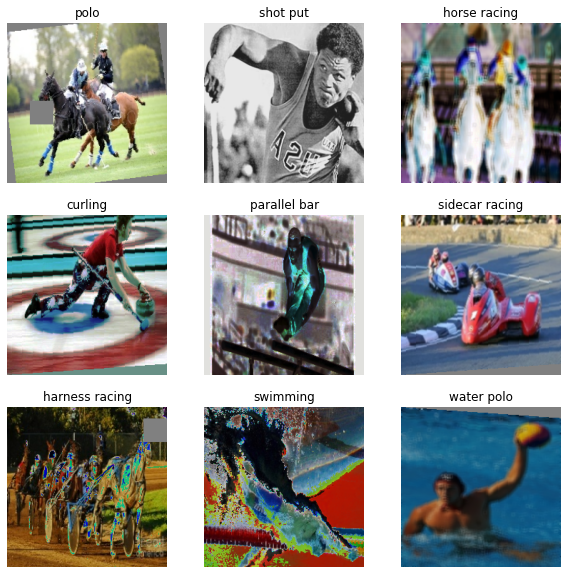

In [106]:
image_batch, label_batch = next(iter(train_ds_rand))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(ins100sport_dataloader.class_names[label])
  plt.axis("off")


### Batch Norm + Instance Norm + Augmentation

In [107]:
dropout_rate = None
kernel_regularizer= None #tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)

resnet34_v2_mix_class = RESNET34_V2_mix(normalization_layers_type= "BN", use_bias=False, 
                       kernel_regularizer=kernel_regularizer, dropout_rate=dropout_rate)
resnet34_v2_mix_model = resnet34_v2_mix_class.build_model(num_classes=100, input_shape=(IMG_HEIGHT,IMG_WIDTH,3))


image_input = layers.Input(shape=(IMG_HEIGHT,IMG_WIDTH,3))
x = tf.keras.layers.Rescaling(scale=1./127.5, offset=-1)(image_input)
x = resnet34_v2_mix_model(x)
sports_classify_resnet34_v2_mix_model = Model(inputs=image_input, outputs=x)

sports_classify_resnet34_v2_mix_model.summary()

Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_11 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 model_22 (Functional)       (None, 100)               21361188  
                                                                 
Total params: 21,361,188
Trainable params: 21,345,956
Non-trainable params: 15,232
_________________________________________________________________


In [108]:
sports_classify_resnet34_v2_mix_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-1, momentum=0.9),
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                      metrics=['accuracy'])


In [109]:
history = sports_classify_resnet34_v2_mix_model.fit(train_ds_rand,
                                epochs = EPOCHS,
                                validation_data = ins100sport_dataloader.val_ds)

Epoch 1/70
425/425 [==============================] - 31s 68ms/step - loss: 4.6569 - accuracy: 0.0143 - val_loss: 4.5770 - val_accuracy: 0.0140
Epoch 2/70
425/425 [==============================] - 29s 68ms/step - loss: 4.4573 - accuracy: 0.0293 - val_loss: 4.4331 - val_accuracy: 0.0340
Epoch 3/70
425/425 [==============================] - 29s 68ms/step - loss: 4.1845 - accuracy: 0.0582 - val_loss: 3.9003 - val_accuracy: 0.0860
Epoch 4/70
425/425 [==============================] - 29s 68ms/step - loss: 3.8484 - accuracy: 0.1084 - val_loss: 3.5339 - val_accuracy: 0.1680
Epoch 5/70
425/425 [==============================] - 29s 68ms/step - loss: 3.5163 - accuracy: 0.1541 - val_loss: 3.5919 - val_accuracy: 0.1740
Epoch 6/70
425/425 [==============================] - 29s 68ms/step - loss: 3.2190 - accuracy: 0.2104 - val_loss: 2.8745 - val_accuracy: 0.2840
Epoch 7/70
425/425 [==============================] - 29s 68ms/step - loss: 2.9496 - accuracy: 0.2692 - val_loss: 2.6351 - val_accuracy:

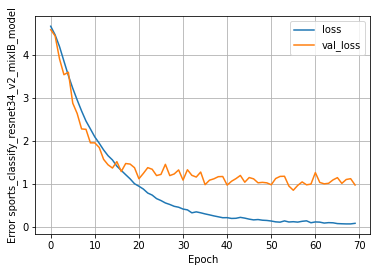

In [110]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Error sports_classify_resnet34_v2_mixIB_model')
plt.legend()
plt.grid(True)

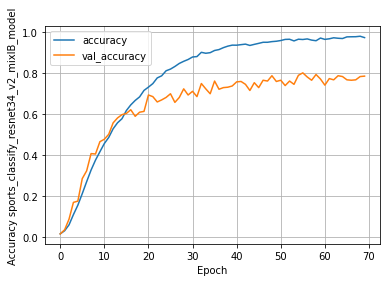

In [111]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy sports_classify_resnet34_v2_mixIB_model')
plt.legend()
plt.grid(True)

In [112]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
65,0.084415,0.975612,1.149007,0.766,65
66,0.080219,0.976127,1.015887,0.764,66
67,0.076833,0.976422,1.106174,0.766,67
68,0.077103,0.978706,1.124903,0.782,68
69,0.090559,0.972075,0.978475,0.784,69


### Batch Norm + Instance Norm + Augmentation + L1L2 regularization

In [114]:
dropout_rate = None
kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)

resnet34_v2_mix_class = RESNET34_V2_mix(normalization_layers_type= "BN", use_bias=False, 
                       kernel_regularizer=kernel_regularizer, dropout_rate=dropout_rate)
resnet34_v2_mix_model = resnet34_v2_mix_class.build_model(num_classes=100, input_shape=(IMG_HEIGHT,IMG_WIDTH,3))


image_input = layers.Input(shape=(IMG_HEIGHT,IMG_WIDTH,3))
x = tf.keras.layers.Rescaling(scale=1./127.5, offset=-1)(image_input)
x = resnet34_v2_mix_model(x)
sports_classify_resnet34_v2_mix_model = Model(inputs=image_input, outputs=x)

sports_classify_resnet34_v2_mix_model.summary()

Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_12 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 model_24 (Functional)       (None, 100)               21361188  
                                                                 
Total params: 21,361,188
Trainable params: 21,345,956
Non-trainable params: 15,232
_________________________________________________________________


In [115]:
sports_classify_resnet34_v2_mix_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-2, momentum=0.9),
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                      metrics=['accuracy'])


In [116]:
history = sports_classify_resnet34_v2_mix_model.fit(train_ds_rand,
                                epochs = EPOCHS,
                                validation_data = ins100sport_dataloader.val_ds)

Epoch 1/70
425/425 [==============================] - 33s 72ms/step - loss: 8.5786 - accuracy: 0.0340 - val_loss: 8.4354 - val_accuracy: 0.0360
Epoch 2/70
425/425 [==============================] - 30s 71ms/step - loss: 8.0091 - accuracy: 0.0823 - val_loss: 7.5115 - val_accuracy: 0.1460
Epoch 3/70
425/425 [==============================] - 32s 74ms/step - loss: 7.4415 - accuracy: 0.1482 - val_loss: 6.8691 - val_accuracy: 0.2440
Epoch 4/70
425/425 [==============================] - 32s 74ms/step - loss: 6.9594 - accuracy: 0.2061 - val_loss: 6.4720 - val_accuracy: 0.3040
Epoch 5/70
425/425 [==============================] - 32s 74ms/step - loss: 6.4932 - accuracy: 0.2732 - val_loss: 6.0070 - val_accuracy: 0.3700
Epoch 6/70
425/425 [==============================] - 32s 74ms/step - loss: 6.1376 - accuracy: 0.3239 - val_loss: 5.6652 - val_accuracy: 0.4080
Epoch 7/70
425/425 [==============================] - 32s 74ms/step - loss: 5.7758 - accuracy: 0.3827 - val_loss: 5.2526 - val_accuracy:

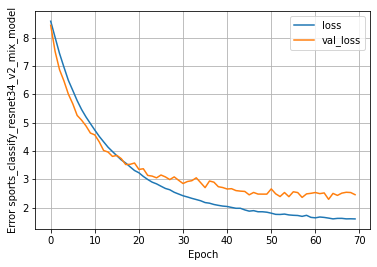

In [117]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Error sports_classify_resnet34_v2_mix_model')
plt.legend()
plt.grid(True)

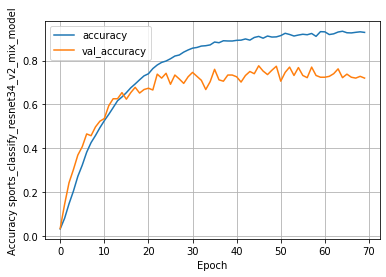

In [118]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy sports_classify_resnet34_v2_mix_model')
plt.legend()
plt.grid(True)

In [119]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
65,1.617904,0.926319,2.429807,0.738,65
66,1.618743,0.925508,2.509399,0.724,66
67,1.601184,0.928308,2.539958,0.720,67
68,1.603984,0.930592,2.531068,0.728,68
69,1.599311,0.927940,2.455036,0.720,69


## Transfer Learning

In [126]:

resnet34_v2_base_model = tf.keras.applications.ResNet50V2(weights="imagenet", include_top=False)


image_input = layers.Input(shape=(IMG_HEIGHT,IMG_WIDTH,3))
x = tf.keras.layers.Rescaling(scale=1./127.5, offset=-1)(image_input)
x = resnet34_v2_base_model(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(units=100, activation="softmax")(x)
sports_classify_resnet34_v2_base_model = Model(inputs=image_input, outputs=x)

sports_classify_resnet34_v2_base_model.summary()

Model: "model_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_14 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, None, None, 2048)  23564800  
                                                                 
 global_average_pooling2d_14  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_14 (Dense)            (None, 100)               204900    
                                                                 
Total params: 23,769,700
Trainable params: 23,724,260
Non-trainable params: 45,440
_________________________________________

In [127]:
resnet34_v2_base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_29 (InputLayer)          [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_29[0][0]']               
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                      

In [128]:
sports_classify_resnet34_v2_base_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-2),
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                      metrics=['accuracy'])


In [129]:
history = sports_classify_resnet34_v2_base_model.fit(ins100sport_dataloader.train_ds,
                                epochs = EPOCHS,
                                validation_data = ins100sport_dataloader.val_ds)

Epoch 1/70
425/425 [==============================] - 34s 78ms/step - loss: 2.0864 - accuracy: 0.5400 - val_loss: 0.5690 - val_accuracy: 0.8420
Epoch 2/70
425/425 [==============================] - 33s 77ms/step - loss: 0.4337 - accuracy: 0.9039 - val_loss: 0.3526 - val_accuracy: 0.8880
Epoch 3/70
425/425 [==============================] - 33s 77ms/step - loss: 0.1445 - accuracy: 0.9790 - val_loss: 0.2843 - val_accuracy: 0.9260
Epoch 4/70
425/425 [==============================] - 33s 77ms/step - loss: 0.0656 - accuracy: 0.9939 - val_loss: 0.2491 - val_accuracy: 0.9220
Epoch 5/70
425/425 [==============================] - 33s 77ms/step - loss: 0.0382 - accuracy: 0.9977 - val_loss: 0.2420 - val_accuracy: 0.9200
Epoch 6/70
425/425 [==============================] - 33s 77ms/step - loss: 0.0280 - accuracy: 0.9977 - val_loss: 0.2579 - val_accuracy: 0.9200
Epoch 7/70
425/425 [==============================] - 33s 76ms/step - loss: 0.0215 - accuracy: 0.9986 - val_loss: 0.2087 - val_accuracy:

KeyboardInterrupt: 